In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import scipy.signal
from scipy import fft
#import psd

from lisainstrument import Instrument

from pytdi import Data
from pytdi import michelson as mich

In [3]:
orbit_path = '../orbits.h5'
gw_path = '../../gws.h5'

nspath = 'measurements/nosigdata.h5'
nnpath = 'measurements/nonoisedata.h5'

rec = ['X','Y','Z']

fs = 4

#dur = [500,1000,5000]
#dur = [1000,5000,10000]
#dur = [1000,5000,10000,50000,100000]

In [6]:
# Create your instrumental setup
inst_nosig = Instrument(
    size=10000, # in samples
    lock='six',
    orbits=orbit_path # realistic orbits (make sure it's consistent with glitches and GWs!)
)

!rm nosigdata.h5
inst_nosig.simulate()
inst_nosig.write(nspath)

inst_nonoise = Instrument(
    size=10000, # in samples
    lock='six',
    orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
    gws=gw_path
)

!rm nonoisedata.h5
inst_nonoise.disable_all_noises()
inst_nonoise.simulate()
inst_nonoise.write(nnpath)

In [7]:
discard = 300

# Calculate no signal data
rawdata = Data.from_instrument(nspath)

X = mich.X2.build(**rawdata.args)(rawdata.measurements)[discard:]
Y = mich.Y2.build(**rawdata.args)(rawdata.measurements)[discard:]
Z = mich.Z2.build(**rawdata.args)(rawdata.measurements)[discard:]

t = inst_nosig.t[discard:]

nsdata = np.array([t,X,Y,Z])

# Calculate no noise data
rawdata = Data.from_instrument(nnpath)

X = mich.X2.build(**rawdata.args)(rawdata.measurements)[discard:]
Y = mich.Y2.build(**rawdata.args)(rawdata.measurements)[discard:]
Z = mich.Z2.build(**rawdata.args)(rawdata.measurements)[discard:]

t = inst_nosig.t[discard:]

nndata = np.array([t,X,Y,Z])


In [8]:
def psd_func(data):
    return scipy.signal.welch(data,fs=4,window='nuttall',nperseg=len(data),detrend=False)

In [9]:
tmp = []
for i in range(3):
    tmpf, tmppsd = psd_func(nsdata[i+1])
    tmp.append(tmppsd)
psd_nsdata = np.array([tmpf, tmp[0], tmp[1], tmp[2]])

In [10]:
fttmp = abs(fft.fft(nndata[1:]))
fft_nndata = np.array([fft.fftfreq(len(nndata[0]),1/fs), fttmp[0],fttmp[1],fttmp[2]])

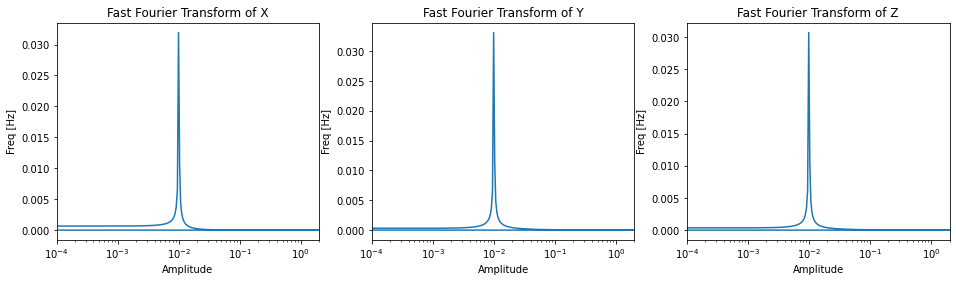

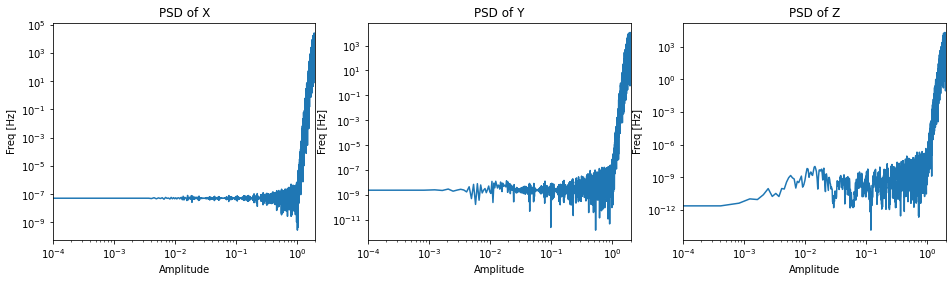

In [11]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(16)
for i in range(3):
    axs[i].plot(fft_nndata[0],fft_nndata[i+1])
    axs[i].set_xlim(1e-4,2)
    axs[i].set_xscale('log')
    axs[i].set_title("Fast Fourier Transform of "+rec[i])
    axs[i].set_ylabel("Freq [Hz]")
    axs[i].set_xlabel("Amplitude")
plt.show()

fig, axs = plt.subplots(1,3)
fig.set_figwidth(16)
for i in range(3):
    axs[i].plot(psd_nsdata[0],psd_nsdata[i+1])
    axs[i].set_xlim(1e-4,2)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_title("PSD of "+rec[i])
    axs[i].set_ylabel("Freq [Hz]")
    axs[i].set_xlabel("Amplitude")
plt.show()


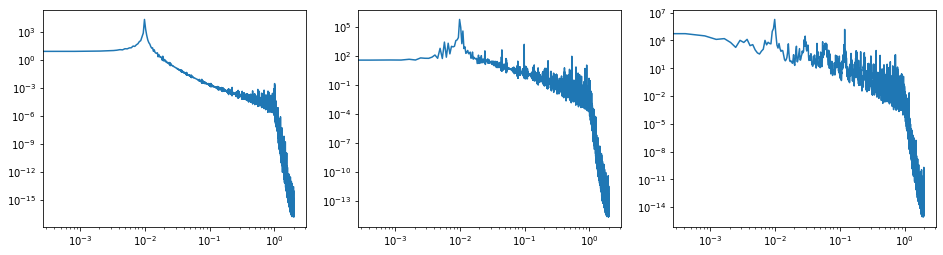

SNR_X = 3.307
SNR_Y = 18.279
SNR_Z = 34.121


In [12]:
# Calculate the SNR
df = (fft_nndata[0][1]-fft_nndata[0][0]) # width of frequency bin
#fft and psd have values at same frequency so no interpolation is needed 

SNR = []

fig, axs = plt.subplots(1,3)
fig.set_figwidth(16)
for i in range(3):
    FFT2 = (fft_nndata[i+1][:int(len(fft_nndata[i+1])/2)])**2 #select the right part of the FFT spectrum
    
    SNR_tmp = np.sqrt(np.sum(FFT2/psd_nsdata[i+1][:-1])*df)
    SNR.append(SNR_tmp)
    
    axs[i].plot(psd_nsdata[0][:-1],FFT2/psd_nsdata[i+1][:-1])
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    #axs[i].set_ylim(ymin=1e-5)
plt.show()

for i in range(3):
    print ("SNR_{} = {:.3f}".format(rec[i],SNR[i]))